# Dt processing

## Init

In [323]:
import os, re, sys
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn
import matplotlib.ticker as mticker
import tensorflow as tf
import itertools
from tqdm import tqdm

from functools import lru_cache

tf.random.set_seed(0)
np.random.seed(0)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.linear_model import LinearRegression


Num GPUs Available:  0


In [324]:

# plt.rc('font', family='serif')
# plt.rcParams.update({'font.size': 11})

dpi_figure = 200
dpi_output = 300


In [325]:
curr_dir = os.getcwd()
curr_dir = os.path.abspath(re.sub(r"\\wsj_notebooks", "", curr_dir))  # remove path after "notebooks"
os.chdir(os.path.join(re.sub(r"\\linear", "", curr_dir), "linear"))
print(os.getcwd())

C:\Users\wangs\Desktop\onvm\linear


In [326]:
def parse_reg(exp_type, exp_num, file, stat_name):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("./data", exp_type, exp_num, file)) as file:
        for line in file:
            parts = line.strip().split(',', 4)
            if len(parts) > 3 and parts[3] == stat_name:
                try:
                    value = float(parts[1])
                except ValueError:
                    value = np.nan
                stat.append(value)
            # if re.search(stat_name, line):
            #     try:
            #         value = float(line.strip().split(',')[index])
            #     except ValueError:
            #         value = np.nan
            #     stat.append(value)

    return stat[:-1]


def parse_reg_all(exp_type, exp_num, file):
    stat = {}
    with open(os.path.join("./data", exp_type, exp_num, file)) as file:
        for line in file:
            parts = line.strip().split(',', 4)
            if len(parts) > 3:
                key = parts[3]
                try:
                    value = float(parts[1])
                except ValueError:
                    value = np.nan
                if key in stat:
                    stat[key].append(value)
                else:
                    stat[key] = [value]
    for key in stat.keys():
        stat[key] = stat[key][:-1]
    return stat


def count_reg_records(exp_type, exp_num, file):
    last_index = ""
    count = 0
    with open(os.path.join("./data", exp_type, exp_num, file)) as file:
        for line in file:
            first_comma = line.find(",")
            if first_comma == -1:
                continue
            index = line[:first_comma]
            if index != last_index:
                count += 1
                last_index = index
    return count

In [327]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []

    lines = []
    with open(os.path.join("./data", exp_type, exp_num, file)) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("<<<<<<< HEAD"):
            j = i
            while j < len(lines) and not lines[j].startswith("======="):
                j += 1
            lines = lines[0:i] + lines[j + 1:-1]
            break
    for i in range(len(lines)):
        if lines[i].startswith(">>>>>>>"):
            lines.pop(i)

    if file.startswith("latency.csv"):
        lines = lines[4:] if exp_type == "load_stimulus" else lines
        for i in range(len(lines)):
            try:
                value = float(lines[i].strip()) / 1000
            except ValueError:
                value = np.nan
            tmp.append(value)
    else:
        for l in lines[1:]:
            try:
                value = float(l.strip().split(",")[index])
            except ValueError:
                value = np.nan
            except IndexError:
                print(l)
            tmp.append(value)

    return tmp

In [328]:
def make_df(exp_type, exp_ls, vnfs, features, debug=False):
    tmp = []
    dic = dict()
    dt_dic = dict()

    tx_stats = parse_seq(exp_type, exp_ls, "tx_stats.csv")
    rx_stats = parse_seq(exp_type, exp_ls, "rx_stats.csv")
    latency = parse_seq(exp_type, exp_ls, "latency.csv")

    tx_stats = tx_stats[1:]
    rx_stats = rx_stats[1:]
    latency = latency[1:]

    seq_length = min(len(tx_stats), len(rx_stats), len(latency),
                     # len(parse_reg(exp_type, exp_ls, "firewall.csv", "instructions", 1)),
                     *map(lambda x: (count_reg_records(exp_type, exp_ls, x)), vnfs)
                     )
    if debug:
        print("seq_length:", seq_length)
        print("tx_stats:", len(tx_stats))
        print("rx_stats:", len(rx_stats))
        print("latency:", len(latency))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    nan_list = set()
    nan_list = nan_list.union(set(np.argwhere(np.isnan(tx_stats)).flatten().tolist()))
    nan_list = nan_list.union(set(np.argwhere(np.isnan(rx_stats)).flatten().tolist()))
    nan_list = nan_list.union(set(np.argwhere(np.isnan(latency)).flatten().tolist()))

    stat = {}
    for v in vnfs:
        stat[v] = parse_reg_all(exp_type, exp_ls, v)

    for f in features:
        for v in vnfs:
            tmp = stat[v][f]
            dt_tmp = np.diff(tmp)
            tmp = tmp[1:seq_length + 1]
            dt_tmp = dt_tmp[:seq_length]
            assert len(tmp) == len(dt_tmp)
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
                dt_tmp = np.pad(dt_tmp, (0, seq_length - len(dt_tmp)), mode='constant')
            nan_list = nan_list.union(set(np.argwhere(np.isnan(tmp)).flatten().tolist()))
            nan_list = nan_list.union(set(np.argwhere(np.isnan(dt_tmp)).flatten().tolist()))
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp
            dt_dic["dt_" + v.split(".")[0] + "_" + f.replace(",", "")] = dt_tmp
            assert len(tmp) == len(dt_tmp) == seq_length

    # remove values greater than seq_length in nan_list
    nan_list = [i for i in nan_list if i < seq_length]
    for key in dic.keys():
        # print(key, "len_dic_key:", len(dic[key]), "max_nan_list:", max(nan_list), "seq_len:", seq_length)
        dic[key] = np.delete(dic[key], list(nan_list))
    for key in dt_dic.keys():
        dt_dic[key] = np.delete(dt_dic[key], list(nan_list))

    dic.update(dt_dic)

    return pd.DataFrame(dic)


In [329]:
if not os.path.exists("./dt_datasets"):
    os.mkdir("./dt_datasets")


In [330]:
def make_dataset(exp_type, exp_ls_list, vnfs, features):
    df_concat = pd.DataFrame()

    for exp_ls in tqdm(exp_ls_list):
        # print("Processing", exp_ls)
        df = make_df(exp_type, exp_ls, vnfs, features)
        # abs_path = os.path.join("./dt_datasets", f"{exp_type}_" + exp_ls + ".csv")
        # df.to_csv(abs_path, sep=',')
        df_concat = pd.concat([df_concat, df], ignore_index=True, copy=False)

    # print("Output concat dataset")
    # abs_path = os.path.join("./dt_datasets", f"{exp_type}_concat.csv")
    # df_concat.to_csv(abs_path, sep=',', index=False)

    # print("Done!")

    return df_concat

## Fixed rate dataset

In [331]:
features = ["instructions", "branches", "branch-misses", "branch-load-misses", "cache-misses", \
            "cache-references", "cycles", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads", ]
vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]


In [332]:
df_fixed_rate_dt = make_dataset("fixed_rate", ["fixed_rate_5000", "fixed_rate_7500"], vnfs, features)
df_random_rate_dt = make_dataset("random_rates", ["exp-1", "exp-2", "exp-3", "exp-4", "exp-5"], vnfs, features)
df_incremental_dt = make_dataset("incremental", ["gaussian_rate", "constant_rate"], vnfs, features)
df_intervention_dt = make_dataset("intervention", [f"exp-{i}" for i in range(1, 59)], vnfs, features)
df_resource_stimulus_dt = make_dataset("resource_stimulus", [f"exp{i}" for i in range(1, 52)], vnfs, features)
df_load_stimulus_dt = make_dataset("load_stimulus", [f"exp{i}" for i in range(1, 10)], vnfs, features)

100%|██████████| 9/9 [00:00<00:00, 19.17it/s]


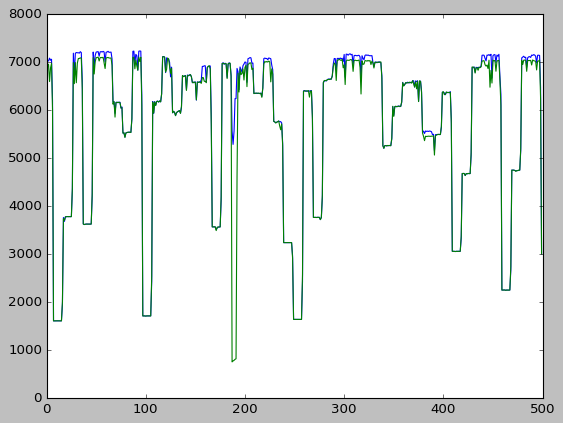

In [333]:
XXX = list(range(500))
YYY1 = df_intervention_dt["input_rate"][:500]
YYY2 = df_intervention_dt["output_rate"][:500]

plt.plot(XXX, YYY1)
plt.plot(XXX, YYY2)
plt.show()

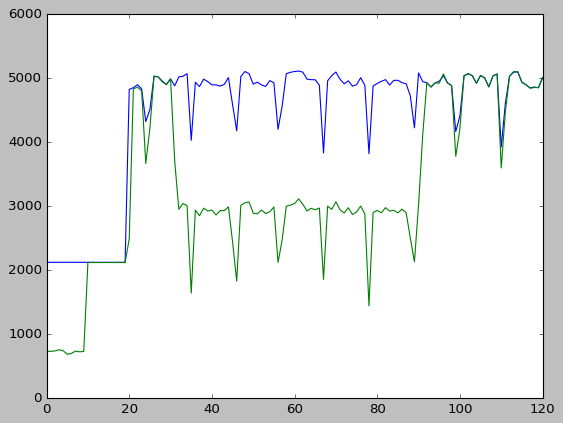

In [334]:

XXX = list(range(len(df_resource_stimulus_dt)-2000))
YYY1 = df_resource_stimulus_dt["input_rate"][2000:]
YYY2 = df_resource_stimulus_dt["output_rate"][2000:]

plt.plot(XXX, YYY1)
plt.plot(XXX, YYY2)
plt.show()


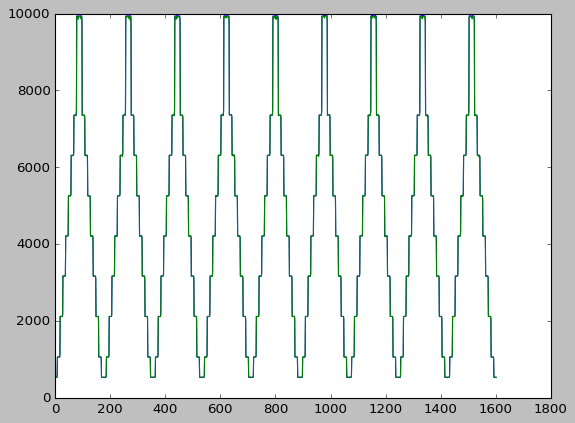

In [335]:
XXX = list(range(len(df_load_stimulus_dt)))
YYY1 = df_load_stimulus_dt["input_rate"]
YYY2 = df_load_stimulus_dt["output_rate"]

plt.plot(XXX, YYY1)
plt.plot(XXX, YYY2)
plt.show()

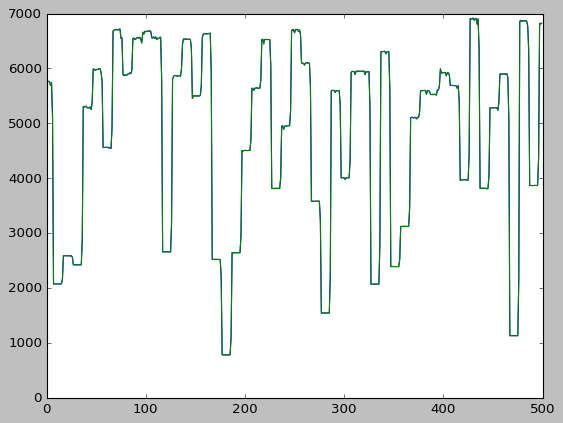

In [336]:
XXX = list(range(500))
YYY1 = df_random_rate_dt["input_rate"][:500]
YYY2 = df_random_rate_dt["output_rate"][:500]

plt.plot(XXX, YYY1)
plt.plot(XXX, YYY2)
plt.show()

In [337]:
# df_random_rate_dt_train, df_random_rate_dt_test = sklearn.model_selection.train_test_split(df_random_rate_dt, test_size=0.3, random_state=0)

df_combined_test_dt = pd.concat(
    [
        # df_fixed_rate_dt,
        df_random_rate_dt, 
        # df_incremental_dt,
        # df_intervention_dt,
        # df_resource_stimulus_dt,
        # df_load_stimulus_dt,
    ],
    ignore_index=True)

df_combined_train_dt = pd.concat(
    [
        # df_fixed_rate_dt,
        # df_random_rate_dt, 
        # df_incremental_dt,
        df_intervention_dt,
        # df_resource_stimulus_dt,
        # df_load_stimulus_dt,
    ],
    ignore_index=True)

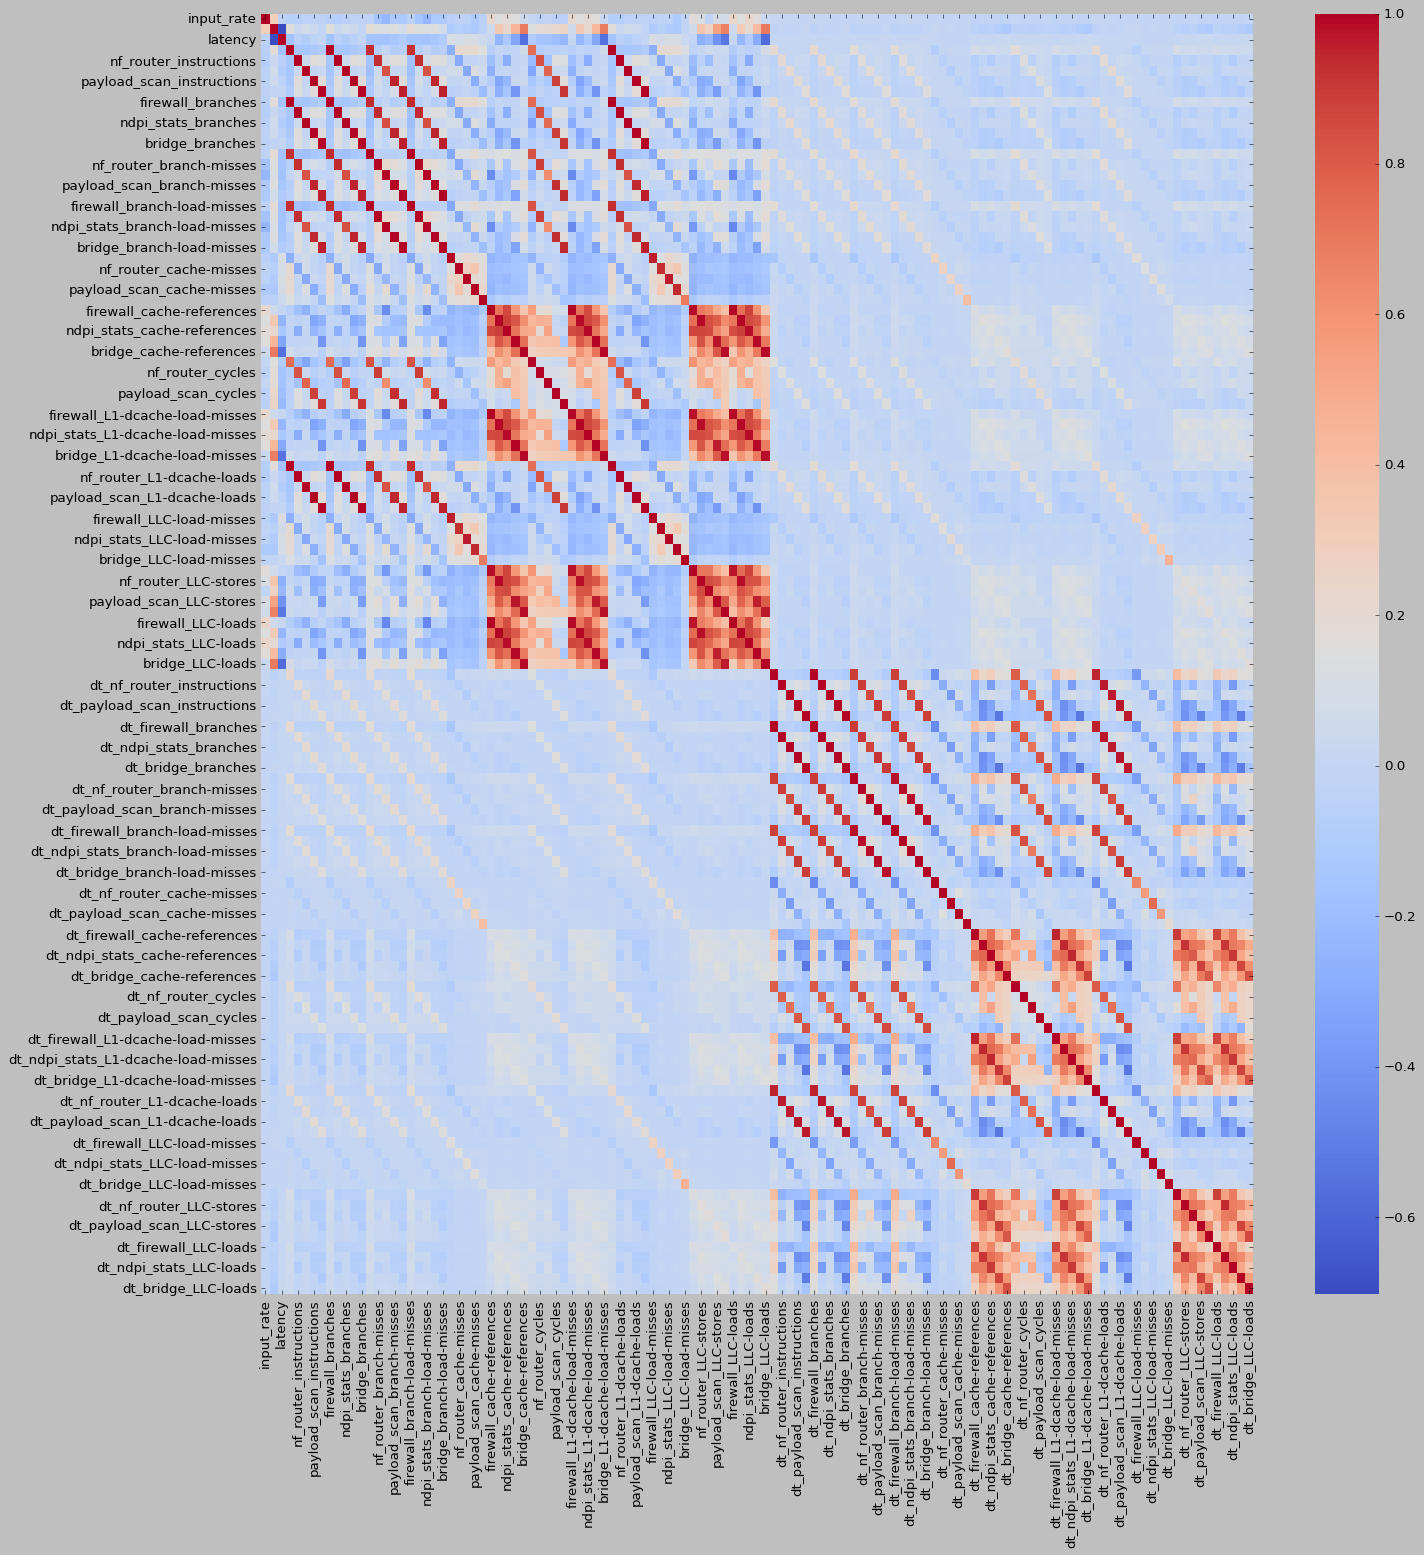

In [338]:
corr = df_combined_train_dt.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f")

plt.show()


In [339]:
for i, name in enumerate(df_combined_train_dt.columns):
    print(i, name)


0 input_rate
1 output_rate
2 latency
3 firewall_instructions
4 nf_router_instructions
5 ndpi_stats_instructions
6 payload_scan_instructions
7 bridge_instructions
8 firewall_branches
9 nf_router_branches
10 ndpi_stats_branches
11 payload_scan_branches
12 bridge_branches
13 firewall_branch-misses
14 nf_router_branch-misses
15 ndpi_stats_branch-misses
16 payload_scan_branch-misses
17 bridge_branch-misses
18 firewall_branch-load-misses
19 nf_router_branch-load-misses
20 ndpi_stats_branch-load-misses
21 payload_scan_branch-load-misses
22 bridge_branch-load-misses
23 firewall_cache-misses
24 nf_router_cache-misses
25 ndpi_stats_cache-misses
26 payload_scan_cache-misses
27 bridge_cache-misses
28 firewall_cache-references
29 nf_router_cache-references
30 ndpi_stats_cache-references
31 payload_scan_cache-references
32 bridge_cache-references
33 firewall_cycles
34 nf_router_cycles
35 ndpi_stats_cycles
36 payload_scan_cycles
37 bridge_cycles
38 firewall_L1-dcache-load-misses
39 nf_router_L1-dcach

In [340]:
def drop_dt_features(dataset):
    # drop all dt features to get baseline
    dt_col_list = [col for col in dataset.columns if col.startswith("dt_")]
    
    return dataset.drop(dt_col_list, axis=1)

df_combined_train_orig = drop_dt_features(df_combined_train_dt)
    
df_combined_test_orig = drop_dt_features(df_combined_test_dt)

In [341]:
def dataset_to_XY(dataset, target, split=True, standardize=True, scaler=None):
    X = dataset.drop(["input_rate", "output_rate", "latency"], axis=1)
    Y = dataset["output_rate"]
    
    if split:
        X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)
        
        column_order = X_train.columns
        X_val = X_val[column_order]
        
        if standardize:
            # Standardize the features
            scaler = sklearn.preprocessing.StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
        
        return X_train, X_val, y_train, y_val, scaler
    else:
        column_order = X.columns
        X = X[column_order]
        
        if standardize:
            # Standardize the features
            if scaler is None:
                raise ValueError("scaler is None")
            X = scaler.transform(X)
        
        return X, Y

# Original dataset (baseline)

In [342]:
X_train_orig, X_val_orig, y_train_orig, y_val_orig, scaler = dataset_to_XY(df_combined_train_orig, "output_rate", standardize=True)
X_test_orig, y_test_orig = dataset_to_XY(df_combined_test_orig, "output_rate", split=False, standardize=True, scaler=scaler)
# randomly sample test set to 10000 samples
X_test_orig, _, y_test_orig, _ = sklearn.model_selection.train_test_split(X_test_orig, y_test_orig, train_size=10000, random_state=0)

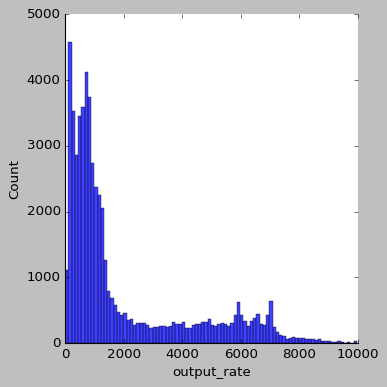

In [343]:
sns.displot(y_train_orig)

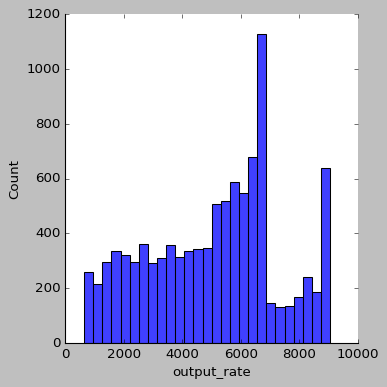

In [344]:
sns.displot(y_test_orig)

# dt dataset

In [345]:
X_train_dt, X_val_dt, y_train_dt, y_val_dt, scaler = dataset_to_XY(df_combined_train_dt, "output_rate", standardize=True)
X_test_dt, y_test_dt = dataset_to_XY(df_combined_test_dt, "output_rate", split=False, standardize=True, scaler=scaler)
# randomly sample test set to 10000 samples
X_test_dt, _, y_test_dt, _ = sklearn.model_selection.train_test_split(X_test_dt, y_test_dt, train_size=10000, random_state=0)

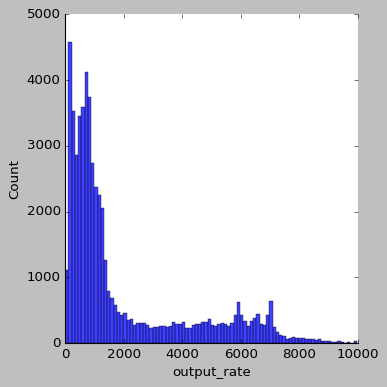

In [346]:
sns.displot(y_train_dt)

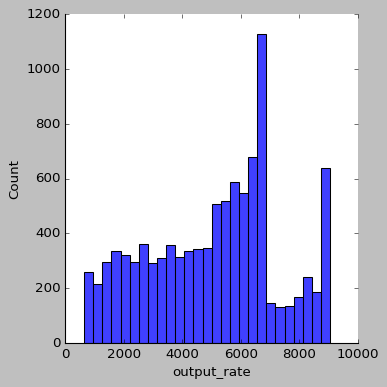

In [347]:
sns.displot(y_test_dt)

## LightGBM

In [348]:
def evaluation(bst, X_test, y_test, show=False, batch_size=None):   
    
    # Make predictions on the test set
    if batch_size is not None:
        y_pred = bst.predict(X_test, batch_size=batch_size)
    else:
        y_pred = bst.predict(X_test)
    if show:
        print("MSE:", sklearn.metrics.mean_squared_error(y_test, y_pred))
    
    # mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    # r2 = sklearn.metrics.r2_score(y_test, y_pred)

    # accuracy
    # threshold = 0.05
    # y_pred = np.array(y_pred)
    # y_test = np.array(y_test)
    # distances = [abs(real - pred) / (1e-9 if real==0 else real) for real, pred in zip(y_test, y_pred)]
    # accuracy_within_threshold = sum(dist <= threshold for dist in distances) / len(distances) * 100

    accuracy_cdf = {}
    # plot cdf of accurancy
    for i in range(21):
        threshold = i / 20
        distances = [abs(real - pred) / (1e-9 if real==0 else real) for real, pred in zip(y_test, y_pred)]
        accuracy_within_threshold = sum(dist <= threshold for dist in distances) / len(distances) * 100
        accuracy_cdf[threshold] = accuracy_within_threshold
    
    if show:
        print(accuracy_cdf)
        # plot
        
        plt.rcParams['figure.dpi'] = dpi_figure
        plt.rcParams['savefig.dpi'] = dpi_output
        
        fig, ax = plt.subplots(facecolor='white', figsize=(8, 6))
        #ax.set_facecolor('white')
        plt.style.use('classic')
        
        plt.plot(y_pred[0:80], marker='o', c='r', markersize=2, linewidth=0.8, linestyle='-', markeredgecolor='red',
                 dashes=(5, 3), label='Prediction')
        plt.plot(y_test.tolist()[0:80], c='b', linestyle='-', linewidth=0.8, label='Real data')
        
        plt.legend(loc="upper right", fontsize=8)
        fig.text(0.5, 0.01, 'Series', size='12', ha='center')
        fig.text(0.01, 0.5, 'Values', size='12', va='center', rotation='vertical')
        plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
        #plt.grid()
        ax.set_facecolor('white')
        
        plt.ylim(0, 10000)
        
        # Set y-axis tick format
        formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x / 1000)}")
        ax.yaxis.set_major_formatter(formatter)
        # Set text in the upper left corner of the figure
        fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')
        
        #save figure
        #folder_path = 'figure/rate_prediction'
        #if not os.path.exists(folder_path):
        #    os.makedirs(folder_path)
        #file_path = os.path.join(folder_path, 'accuracy-linear.pdf' )
        #plt.savefig(file_path)
        
        plt.show()

    return accuracy_cdf

def show_acc_plot(acc_dict_list, legend=None):
    plt.rcParams['figure.dpi'] = dpi_figure
    plt.rcParams['savefig.dpi'] = dpi_output

    fig, ax = plt.subplots(facecolor='white', figsize=(8, 6))
    #ax.set_facecolor('white')
    plt.style.use('classic')

    for acc_dict in acc_dict_list:
        plt.plot(list(acc_dict.keys()), list(acc_dict.values()), marker='o', markersize=2, linewidth=0.8, linestyle='-', markeredgecolor='red',
                 dashes=(5, 3), label='Prediction')

    plt.legend(loc="upper right", fontsize=8)
    fig.text(0.5, 0.01, 'Threshold', size='12', ha='center')
    fig.text(0.01, 0.5, 'Accuracy', size='12', va='center', rotation='vertical')
    plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
    #plt.grid()
    ax.set_facecolor('white')

    plt.ylim(0, 100)

    # Set y-axis tick format
    formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x)}")
    ax.yaxis.set_major_formatter(formatter)
    # Set text in the upper left corner of the figure
    fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')
    
    if legend is not None:
        plt.legend(loc="lower right", fontsize=8, labels=legend)

    #save figure
    #folder_path = 'figure/rate_prediction'
    #if not os.path.exists(folder_path):
    #    os.makedirs(folder_path)
    #file_path = os.path.join(folder_path, 'accuracy-linear.pdf' )
    #plt.savefig(file_path)

    plt.show()

In [349]:
grid_lr = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
grid_tree = [5, 10, 20, 40, 70, 100, ]

acc = {}
with tqdm([(lr, nt) for lr in grid_lr for nt in grid_tree]) as prog:
    for lr, nt in prog:
        prog.set_postfix_str(f"lr={lr}, nt={nt}")
        train_data = lgb.Dataset(X_train_orig, label=y_train_orig)
        param = {'objective': 'mean_squared_error', 'boosting': 'dart', 'learning_rate': lr, 'verbosity': 0,}
        bst = lgb.train(param, train_data, num_boost_round = nt)
        acc[(lr, nt)] = evaluation(bst, X_val_orig, y_val_orig)[0.1]

print(sorted(acc.keys(), key=lambda x: acc[x], reverse=True))

# [(0.2, 5000), (0.1, 5000), (0.2, 2000), (0.05, 5000), (0.5, 5000), (0.1, 2000), (0.5, 2000), (0.2, 1000), (0.5, 1000), (0.02, 5000), (0.2, 500), (0.5, 500), (0.1, 1000), (0.05, 2000), (0.8, 5000), (0.8, 2000), (0.8, 1000), (0.1, 500), (0.5, 200), (1, 5000), (0.8, 500), (0.01, 5000), (0.05, 1000), (0.2, 200), (1, 1000), (1, 2000), (0.8, 200), (1, 500), (0.5, 100), (0.02, 2000), (0.05, 500), (1, 200), (0.2, 100), (0.8, 100), (0.1, 200), (1, 100), (1.5, 1000), (1.5, 200), (1.5, 500), (1.5, 5000), (0.02, 1000), (1.5, 2000), (1.5, 100), (0.01, 2000), (0.1, 100), (0.02, 500), (2, 500), (0.05, 200), (2, 1000), (0.01, 1000), (2, 2000), (0.05, 100), (0.02, 100), (0.01, 500), (0.01, 100), (2, 200), (0.02, 200), (2, 5000), (0.01, 200), (2, 100)]

100%|██████████| 54/54 [00:34<00:00,  1.58it/s, lr=0.5, nt=100]  

[(0.5, 100), (0.2, 70), (0.2, 100), (0.5, 70), (0.5, 40), (0.5, 20), (0.2, 40), (0.2, 20), (0.5, 10), (0.5, 5), (0.1, 100), (0.1, 40), (0.1, 70), (0.2, 10), (0.1, 20), (0.05, 100), (0.05, 70), (0.02, 100), (0.02, 70), (0.05, 40), (0.01, 100), (0.01, 70), (0.005, 70), (0.2, 5), (0.005, 100), (0.002, 70), (0.002, 100), (0.001, 100), (0.001, 70), (0.1, 10), (0.05, 20), (0.02, 40), (0.1, 5), (0.05, 10), (0.02, 20), (0.01, 40), (0.05, 5), (0.02, 10), (0.01, 20), (0.005, 40), (0.02, 5), (0.01, 10), (0.005, 20), (0.002, 40), (0.01, 5), (0.002, 20), (0.005, 10), (0.001, 40), (0.005, 5), (0.002, 5), (0.001, 10), (0.001, 20), (0.002, 10), (0.001, 5)]


In [350]:
lr, nt = 0.2, 100

train_data_orig = lgb.Dataset(X_train_orig, label=y_train_orig)
train_data_dt = lgb.Dataset(X_train_dt, label=y_train_dt)
valid_data_orig = lgb.Dataset(X_val_orig, label=y_val_orig, reference=train_data_orig)
valid_data_dt = lgb.Dataset(X_val_dt, label=y_val_dt, reference=train_data_dt)

param = {'objective': 'mean_squared_error', 'boosting_type': 'dart', 'learning_rate': lr, 'verbosity': 0, 'seed': 0, }


In [351]:
force_train=True

In [352]:
# force_train=False

In [353]:
if not os.path.exists("./models"):
    os.mkdir("./models")

if not os.path.exists("./models/lgb_orig.txt") or force_train:
    # bst_orig = lgb.train(param, train_data_orig, num_boost_round = nt)
    # bst_orig.save_model("./models/lgb_orig.txt")
    bst_orig = lgb.LGBMRegressor(boosting_type='dart', learning_rate=lr, num_boost_round=nt, objective='mean_squared_error', random_state=0)
    bst_orig.fit(X_train_orig, y_train_orig, eval_set=[(X_train_orig, y_train_orig), (X_val_orig, y_val_orig)], eval_metric='mse')
    bst_orig.booster_.save_model("./models/lgb_orig.txt")
else:
    bst_orig = lgb.Booster(model_file="./models/lgb_orig.txt")

Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 56927, number of used features: 60
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Start training from score 1959.633794


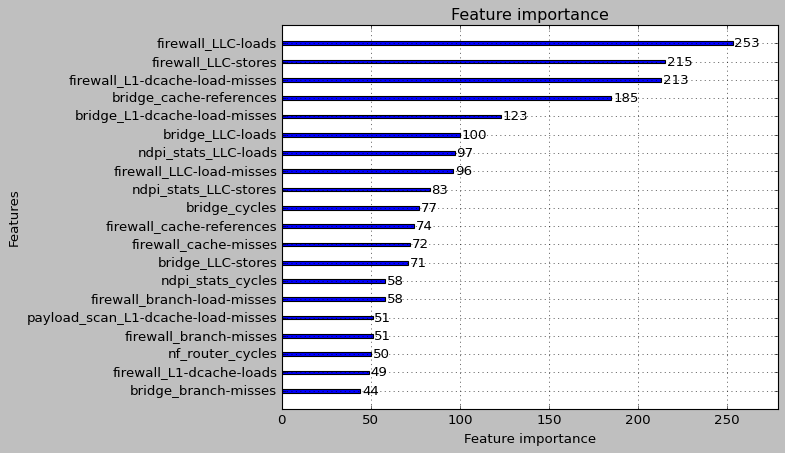

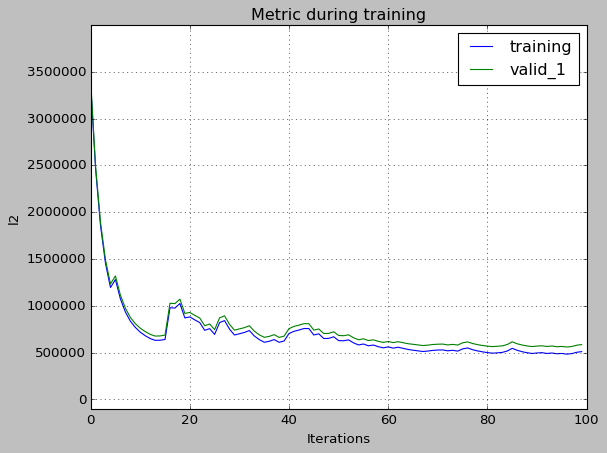

In [354]:
if type(bst_orig) == lgb.sklearn.LGBMRegressor:
    bst_orig.booster_.feature_name = lambda : list(df_combined_test_orig.drop(["input_rate", "output_rate", "latency"], axis=1).columns)
    lgb.plot_importance(bst_orig, max_num_features=20)
    lgb.plot_metric(bst_orig)

In [355]:
feat_importance_orig = bst_orig.booster_.feature_importance()
feat_importance_orig = {df_combined_test_orig.drop(["input_rate", "output_rate", "latency"], axis=1).columns[i]: feat_importance_orig[i] for i in range(len(df_combined_test_orig.drop(["input_rate", "output_rate", "latency"], axis=1).columns))}
feat_importance_orig = sorted(feat_importance_orig.items(), key=lambda x: x[1], reverse=True)
for i in feat_importance_orig:
    print(i)

('firewall_LLC-loads', 253)
('firewall_LLC-stores', 215)
('firewall_L1-dcache-load-misses', 213)
('bridge_cache-references', 185)
('bridge_L1-dcache-load-misses', 123)
('bridge_LLC-loads', 100)
('ndpi_stats_LLC-loads', 97)
('firewall_LLC-load-misses', 96)
('ndpi_stats_LLC-stores', 83)
('bridge_cycles', 77)
('firewall_cache-references', 74)
('firewall_cache-misses', 72)
('bridge_LLC-stores', 71)
('firewall_branch-load-misses', 58)
('ndpi_stats_cycles', 58)
('firewall_branch-misses', 51)
('payload_scan_L1-dcache-load-misses', 51)
('nf_router_cycles', 50)
('firewall_L1-dcache-loads', 49)
('bridge_branch-misses', 44)
('ndpi_stats_branch-load-misses', 43)
('payload_scan_cache-misses', 43)
('firewall_cycles', 43)
('ndpi_stats_cache-misses', 42)
('ndpi_stats_LLC-load-misses', 40)
('payload_scan_LLC-loads', 40)
('firewall_branches', 38)
('payload_scan_cycles', 36)
('ndpi_stats_branch-misses', 35)
('payload_scan_cache-references', 35)
('bridge_L1-dcache-loads', 35)
('bridge_branch-load-misses',

In [356]:
if not os.path.exists("./models"):
    os.mkdir("./models")
    
if not os.path.exists("./models/lgb_dt.txt") or force_train:
    # bst_dt = lgb.train(param, train_data_dt, num_boost_round = nt)
    # bst_dt.save_model("./models/lgb_dt.txt")
    bst_dt = lgb.LGBMRegressor(boosting_type='dart', learning_rate=lr, num_boost_round=nt, objective='mean_squared_error', random_state=0)
    bst_dt.fit(X_train_dt, y_train_dt, eval_set=[(X_train_dt, y_train_dt), (X_val_dt, y_val_dt)], eval_metric='mse')
    bst_dt.booster_.save_model("./models/lgb_dt.txt")
else:
    bst_dt = lgb.Booster(model_file="./models/lgb_dt.txt")

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 56927, number of used features: 120
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Start training from score 1959.633794


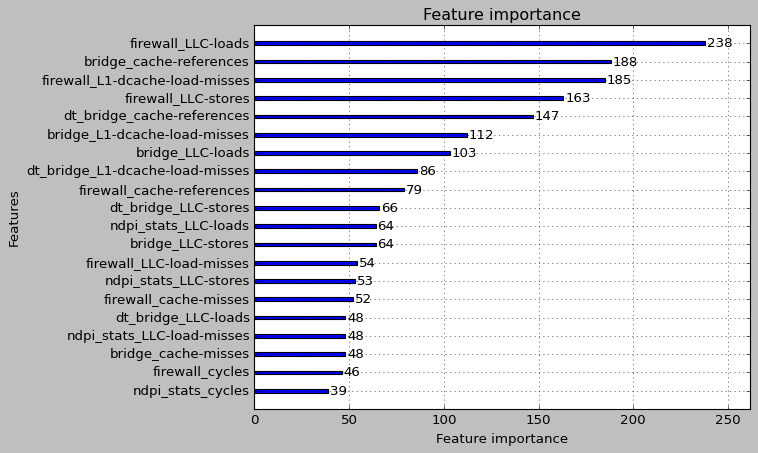

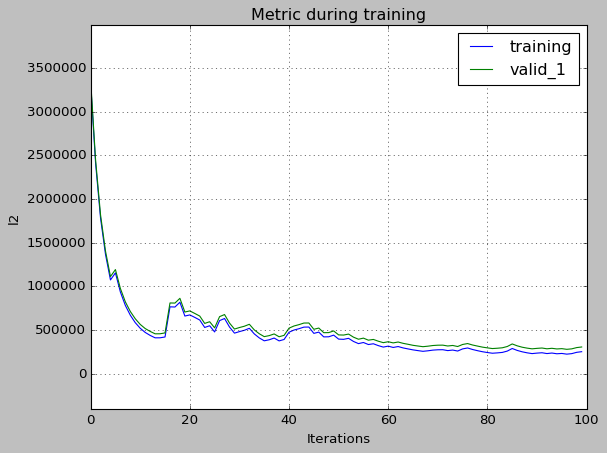

In [357]:
if type(bst_dt) == lgb.sklearn.LGBMRegressor:
    bst_dt.booster_.feature_name = lambda : list(df_combined_test_dt.drop(["input_rate", "output_rate", "latency"], axis=1).columns)
    lgb.plot_importance(bst_dt, max_num_features=20)
    lgb.plot_metric(bst_dt)

In [358]:
feat_importance_dt = bst_dt.booster_.feature_importance()
feat_importance_dt = {df_combined_test_dt.drop(["input_rate", "output_rate", "latency"], axis=1).columns[i]: feat_importance_dt[i] for i in range(len(df_combined_test_dt.drop(["input_rate", "output_rate", "latency"], axis=1).columns))}
feat_importance_dt = sorted(feat_importance_dt.items(), key=lambda x: x[1], reverse=True)
for i in feat_importance_dt:
    print(i)

('firewall_LLC-loads', 238)
('bridge_cache-references', 188)
('firewall_L1-dcache-load-misses', 185)
('firewall_LLC-stores', 163)
('dt_bridge_cache-references', 147)
('bridge_L1-dcache-load-misses', 112)
('bridge_LLC-loads', 103)
('dt_bridge_L1-dcache-load-misses', 86)
('firewall_cache-references', 79)
('dt_bridge_LLC-stores', 66)
('bridge_LLC-stores', 64)
('ndpi_stats_LLC-loads', 64)
('firewall_LLC-load-misses', 54)
('ndpi_stats_LLC-stores', 53)
('firewall_cache-misses', 52)
('bridge_cache-misses', 48)
('ndpi_stats_LLC-load-misses', 48)
('dt_bridge_LLC-loads', 48)
('firewall_cycles', 46)
('ndpi_stats_cycles', 39)
('payload_scan_cycles', 38)
('payload_scan_cache-references', 37)
('firewall_branch-misses', 36)
('payload_scan_LLC-loads', 36)
('dt_firewall_L1-dcache-load-misses', 36)
('nf_router_cycles', 34)
('bridge_cycles', 32)
('dt_bridge_cycles', 30)
('dt_payload_scan_L1-dcache-load-misses', 30)
('firewall_branches', 28)
('payload_scan_cache-misses', 27)
('firewall_L1-dcache-loads', 2

In [359]:
acc_lgb_orig = evaluation(bst_orig, X_test_orig, y_test_orig, show=False)
acc_lgb_dt = evaluation(bst_dt, X_test_dt, y_test_dt, show=False)

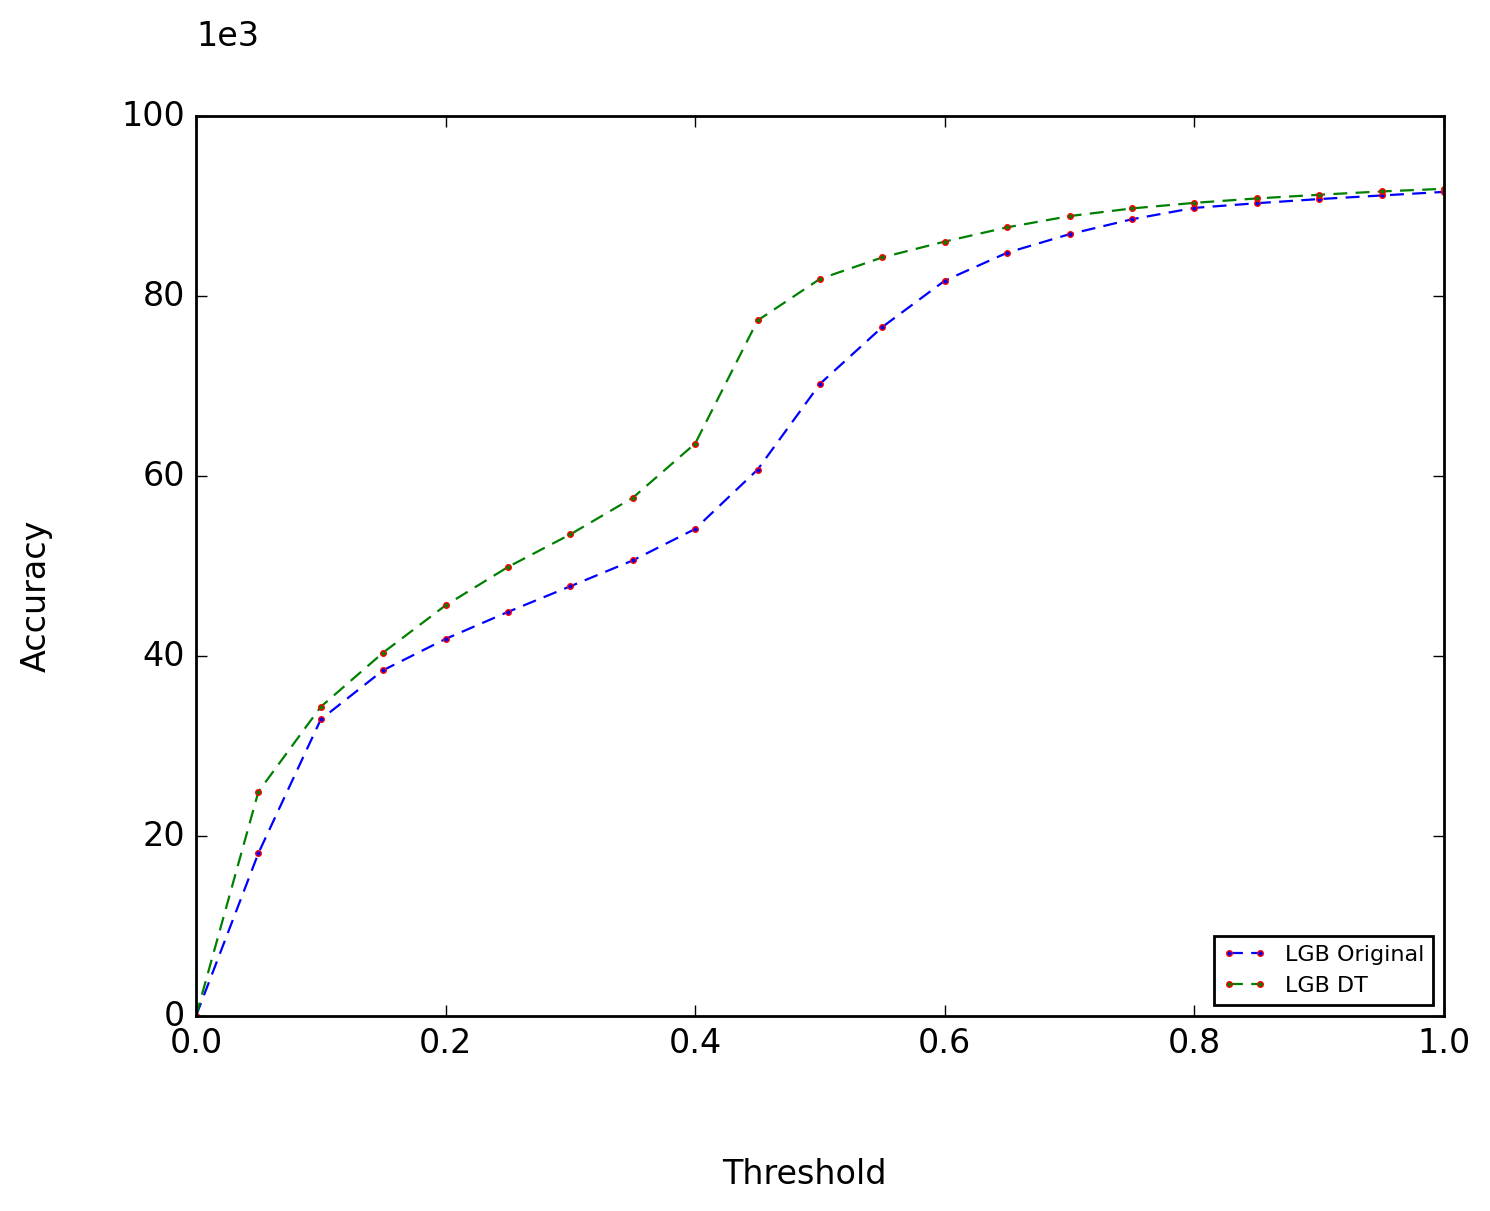

In [360]:
show_acc_plot([acc_lgb_orig, acc_lgb_dt], legend = ["LGB Original", "LGB DT"])

## ANN

In [361]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [362]:
def ann_train(X_train, y_train, validation_data=None):
    with tf.device('/CPU:0'):
        # model
        model = Sequential()
    
        # Add input layer and hidden layers
        model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dense(16, activation='relu'))
    
        # Add input layer and hidden layers with L2 regularization
        #model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
        #model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        # Add output layer
        model.add(Dense(1))
        
        # 0.01 100
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mse'])
        history = model.fit(X_train, y_train, validation_data=validation_data, batch_size=8, epochs=100, verbose=1)
        
        return model, history

In [363]:
if not os.path.exists("./models"):
    os.mkdir("./models")
    
if not os.path.exists("./models/ann_orig") or force_train:
    ann_orig, ann_orig_history = ann_train(X_train_orig, y_train_orig, (X_val_orig[:100], y_val_orig[:100]))
    ann_orig.save("./models/ann_orig")
else:
    ann_orig = tf.keras.models.load_model("./models/ann_orig")


Epoch 1/100
7116/7116 [==============================] - 9s 1ms/step - loss: 1831642.0000 - mse: 1831642.0000 - val_loss: 1288635.3750 - val_mse: 1288635.3750
Epoch 2/100
7116/7116 [==============================] - 7s 1ms/step - loss: 1485145.7500 - mse: 1485145.7500 - val_loss: 1024198.5625 - val_mse: 1024198.5625
Epoch 3/100
7116/7116 [==============================] - 7s 951us/step - loss: 1137492.1250 - mse: 1137492.1250 - val_loss: 1040212.5625 - val_mse: 1040212.5625
Epoch 4/100
7116/7116 [==============================] - 7s 1ms/step - loss: 1014670.6875 - mse: 1014670.6875 - val_loss: 754984.8750 - val_mse: 754984.8750
Epoch 5/100
7116/7116 [==============================] - 8s 1ms/step - loss: 907971.4375 - mse: 907971.4375 - val_loss: 589937.8125 - val_mse: 589937.8125
Epoch 6/100
7116/7116 [==============================] - 7s 1ms/step - loss: 833874.5000 - mse: 833874.5000 - val_loss: 563788.6875 - val_mse: 563788.6875
Epoch 7/100
7116/7116 [==============================]

INFO:tensorflow:Assets written to: ./models/ann_orig\assets


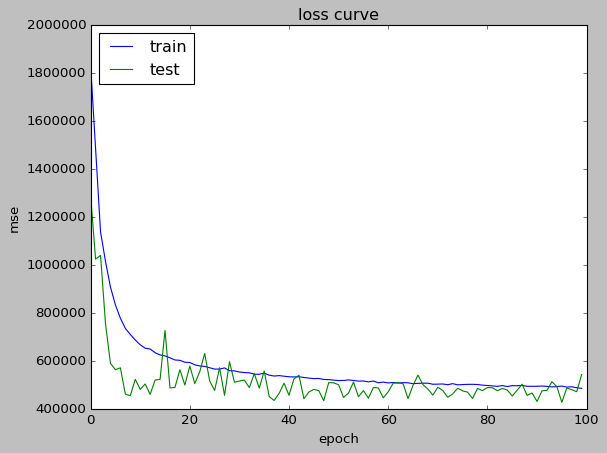

In [364]:
plt.plot(ann_orig_history.history['mse'])
plt.plot(ann_orig_history.history['val_mse'])
plt.title('loss curve')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [365]:
if not os.path.exists("./models"):
    os.mkdir("./models")
    
if not os.path.exists("./models/ann_dt") or force_train:
    ann_dt, ann_dt_history = ann_train(X_train_dt, y_train_dt, (X_val_dt[:100], y_val_dt[:100]))
    ann_dt.save("./models/ann_dt")
else:
    ann_dt = tf.keras.models.load_model("./models/ann_orig")


Epoch 1/100
7116/7116 [==============================] - 8s 992us/step - loss: 1184961.1250 - mse: 1184961.1250 - val_loss: 751585.7500 - val_mse: 751585.7500
Epoch 2/100
7116/7116 [==============================] - 7s 951us/step - loss: 753303.4375 - mse: 753303.4375 - val_loss: 631924.8750 - val_mse: 631924.8750
Epoch 3/100
7116/7116 [==============================] - 7s 915us/step - loss: 658116.8750 - mse: 658116.8750 - val_loss: 668642.4375 - val_mse: 668642.4375
Epoch 4/100
7116/7116 [==============================] - 8s 1ms/step - loss: 589134.3125 - mse: 589134.3125 - val_loss: 493150.0000 - val_mse: 493150.0000
Epoch 5/100
7116/7116 [==============================] - 7s 958us/step - loss: 536089.4375 - mse: 536089.4375 - val_loss: 419689.0938 - val_mse: 419689.0938
Epoch 6/100
7116/7116 [==============================] - 7s 920us/step - loss: 501147.8125 - mse: 501147.8125 - val_loss: 394716.2500 - val_mse: 394716.2500
Epoch 7/100
7116/7116 [==============================] - 7

INFO:tensorflow:Assets written to: ./models/ann_dt\assets


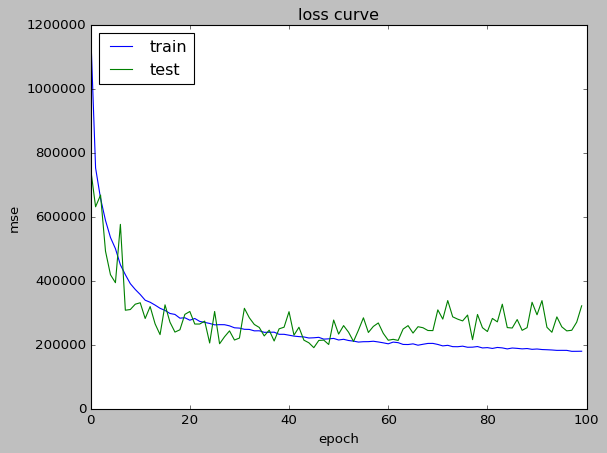

In [366]:
plt.plot(ann_dt_history.history['mse'])
plt.plot(ann_dt_history.history['val_mse'])
plt.title('loss curve')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [367]:
print(len(X_test_orig))         # test samples
print(len(X_test_orig) / 32)    # batch num

10000
312.5


In [368]:
acc_ann_orig = evaluation(ann_orig, X_test_orig, y_test_orig, show=False, batch_size=32)
acc_ann_dt = evaluation(ann_dt, X_test_dt, y_test_dt, show=False, batch_size=32)

313/313 [==============================] - 0s 760us/step


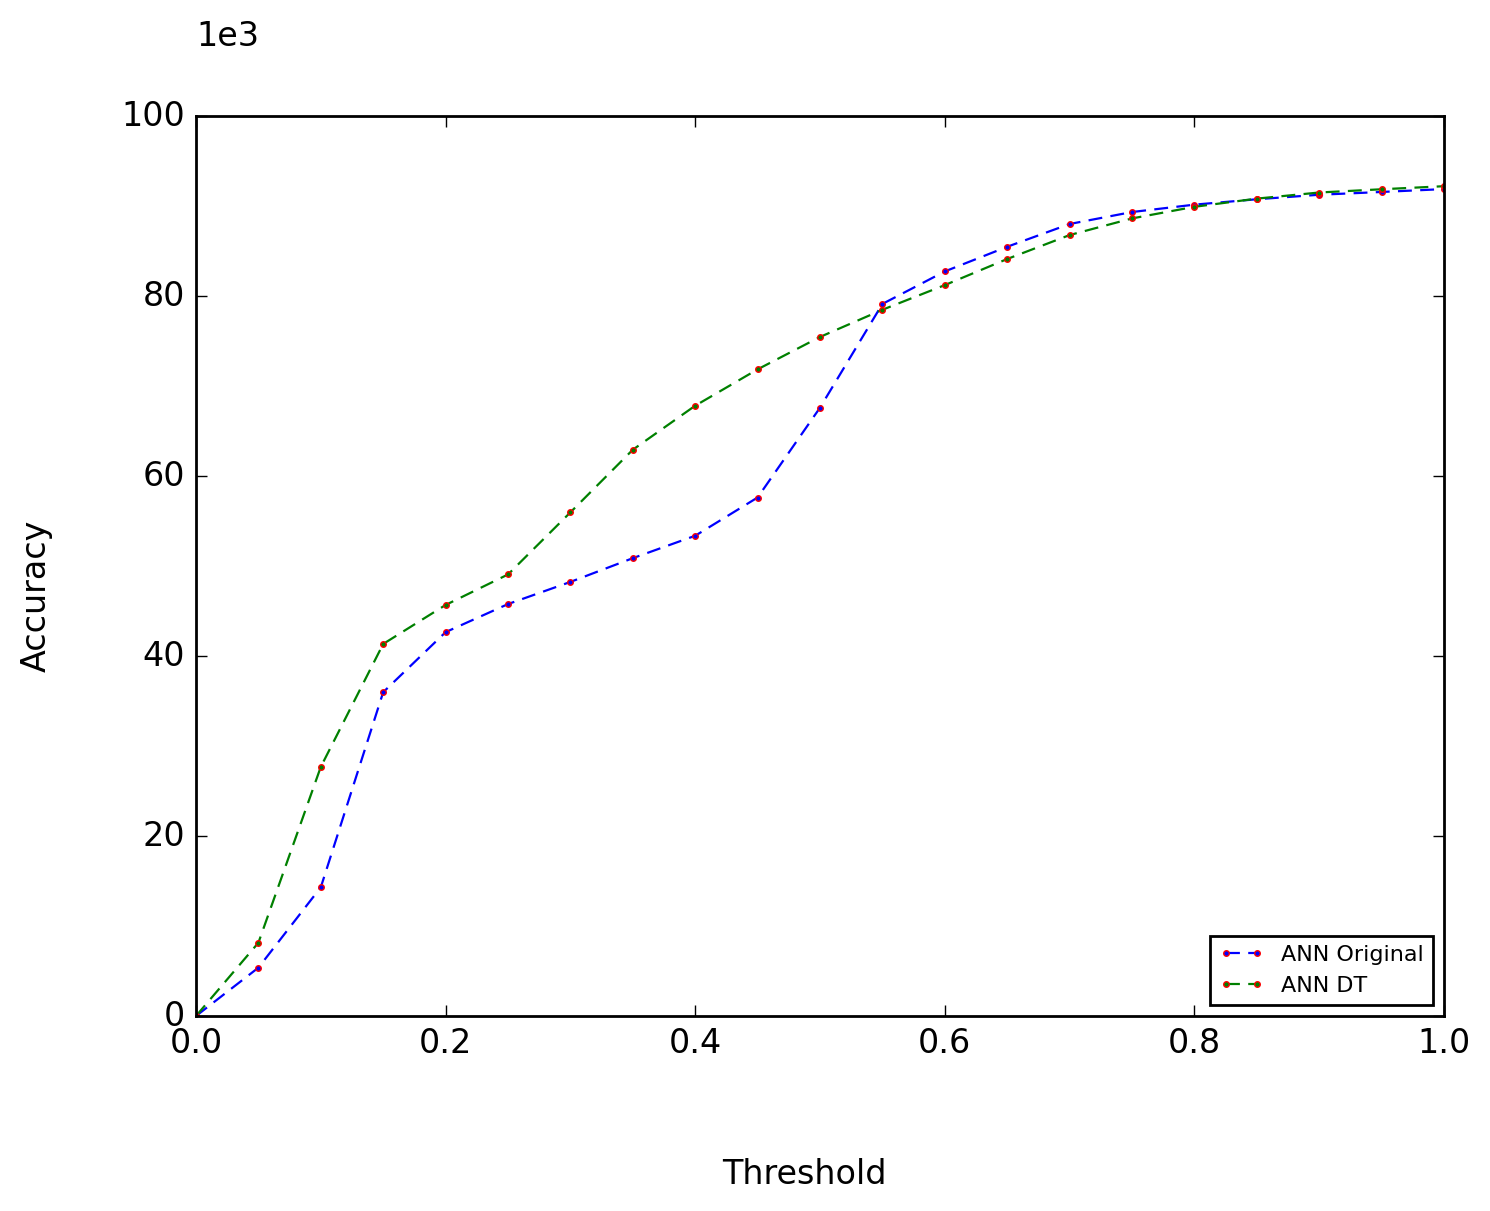

In [369]:
show_acc_plot([acc_ann_orig, acc_ann_dt], legend = ["ANN Original", "ANN DT"])

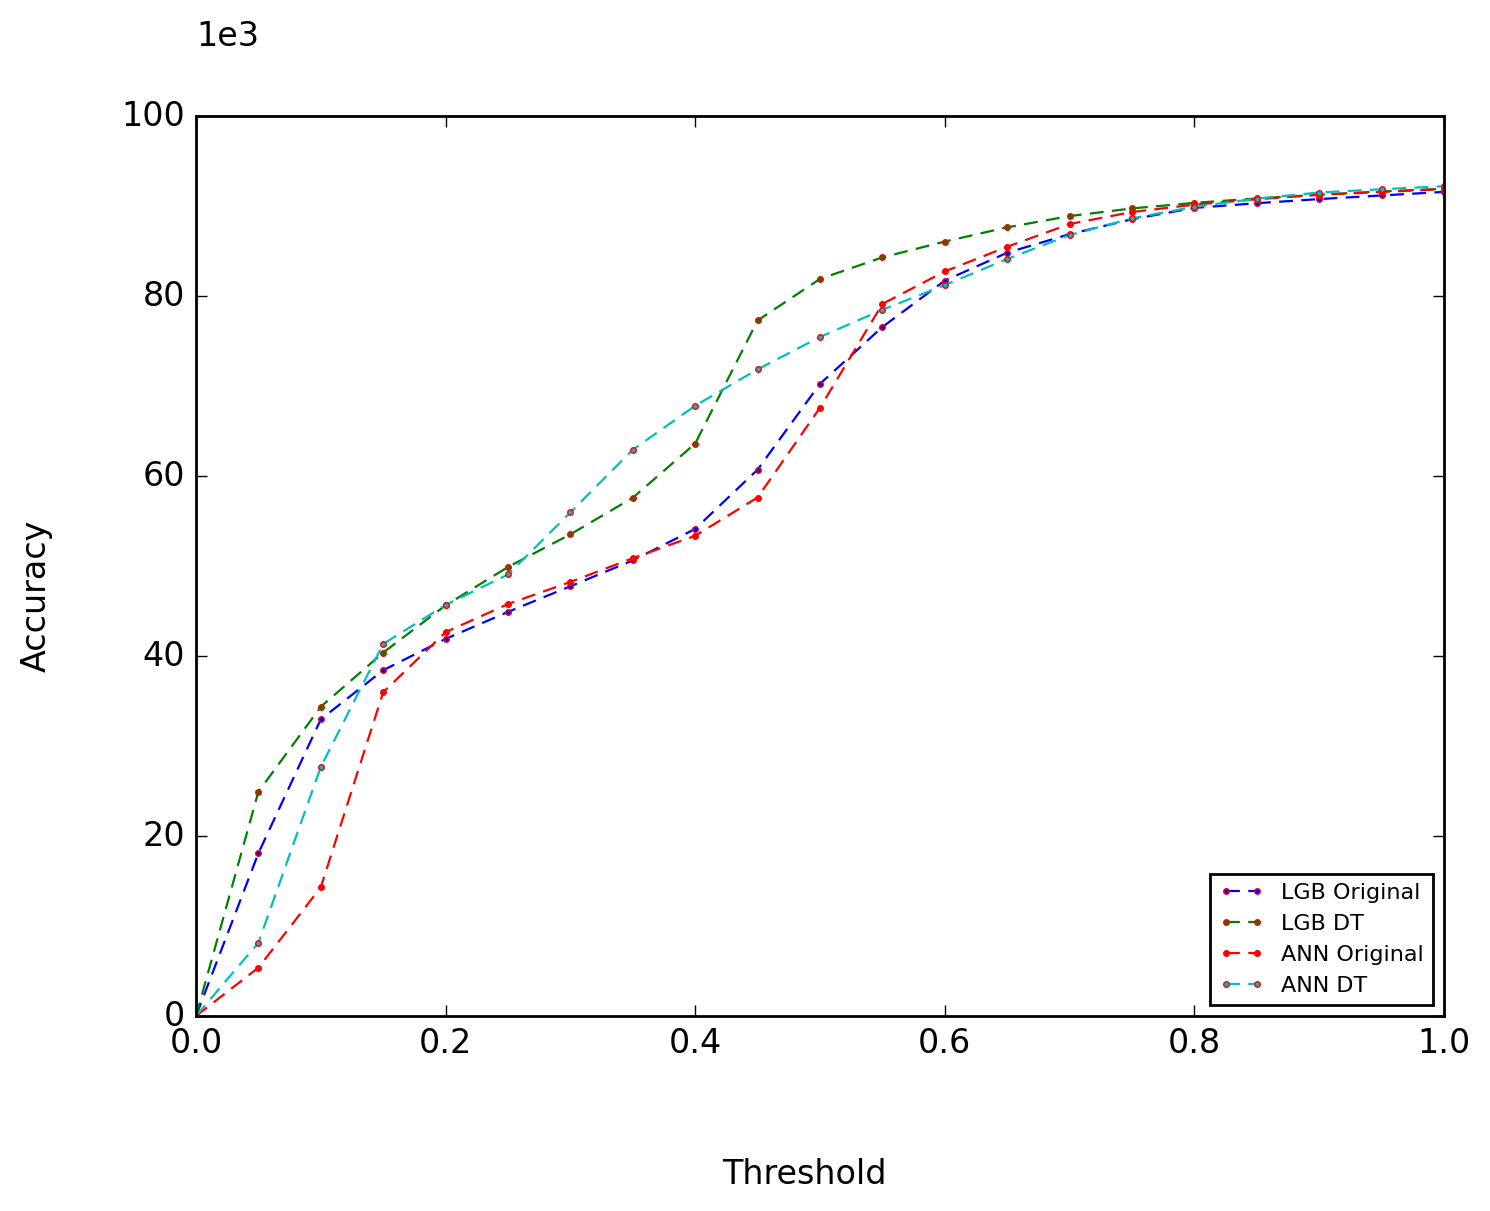

In [370]:
show_acc_plot([acc_lgb_orig, acc_lgb_dt, acc_ann_orig, acc_ann_dt], legend = ["LGB Original", "LGB DT", "ANN Original", "ANN DT"])

1/1 [==============================] - 0s 27ms/step


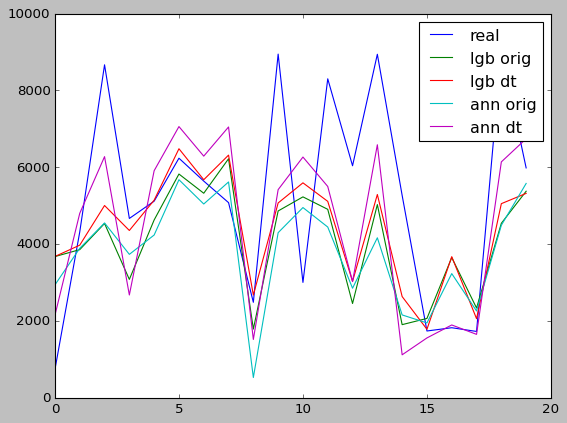

In [371]:
test_num = 20

XXX = list(range(test_num))
YYY_real = y_test_orig[:test_num]
YYY_lgb_orig = bst_orig.predict(X_test_orig[:test_num])
YYY_lgb_dt = bst_dt.predict(X_test_dt[:test_num])
YYY_ann_orig = ann_orig.predict(X_test_orig[:test_num])
YYY_ann_dt = ann_dt.predict(X_test_dt[:test_num])

plt.plot(XXX, YYY_real)
plt.plot(XXX, YYY_lgb_orig)
plt.plot(XXX, YYY_lgb_dt)
plt.plot(XXX, YYY_ann_orig)
plt.plot(XXX, YYY_ann_dt)
plt.legend(["real", "lgb orig", 'lgb dt', 'ann orig', 'ann dt'])
plt.show()

# SHAP

In [407]:
import shap

In [417]:
# even smaller test set for SHAP evaluation
X_test_orig_smaller, _, y_test_orig_smaller, _ = sklearn.model_selection.train_test_split(X_test_orig, y_test_orig, train_size=50, random_state=0)
X_test_dt_smaller, _, y_test_dt_smaller, _ = sklearn.model_selection.train_test_split(X_test_dt, y_test_dt, train_size=50, random_state=0)

In [409]:
print(len(X_test_orig_smaller), len(X_test_dt_smaller))

500 500


In [410]:
explainer_orig = shap.TreeExplainer(bst_orig)
shap_values_orig = explainer_orig(X_test_orig)

In [411]:
explainer_dt = shap.TreeExplainer(bst_dt)
shap_values_dt = explainer_dt(X_test_dt)

In [412]:
feature_list = []
for i, name in enumerate(df_combined_train_dt.drop(["input_rate", "output_rate", "latency"], axis=1)):
    feature_list.append(name)
    print(i, name)

0 firewall_instructions
1 nf_router_instructions
2 ndpi_stats_instructions
3 payload_scan_instructions
4 bridge_instructions
5 firewall_branches
6 nf_router_branches
7 ndpi_stats_branches
8 payload_scan_branches
9 bridge_branches
10 firewall_branch-misses
11 nf_router_branch-misses
12 ndpi_stats_branch-misses
13 payload_scan_branch-misses
14 bridge_branch-misses
15 firewall_branch-load-misses
16 nf_router_branch-load-misses
17 ndpi_stats_branch-load-misses
18 payload_scan_branch-load-misses
19 bridge_branch-load-misses
20 firewall_cache-misses
21 nf_router_cache-misses
22 ndpi_stats_cache-misses
23 payload_scan_cache-misses
24 bridge_cache-misses
25 firewall_cache-references
26 nf_router_cache-references
27 ndpi_stats_cache-references
28 payload_scan_cache-references
29 bridge_cache-references
30 firewall_cycles
31 nf_router_cycles
32 ndpi_stats_cycles
33 payload_scan_cycles
34 bridge_cycles
35 firewall_L1-dcache-load-misses
36 nf_router_L1-dcache-load-misses
37 ndpi_stats_L1-dcache-lo

In [413]:
shap_values_orig.feature_names = feature_list[:len(X_test_orig_smaller[0])]
shap_values_dt.feature_names = feature_list[:len(X_test_dt_smaller[0])]

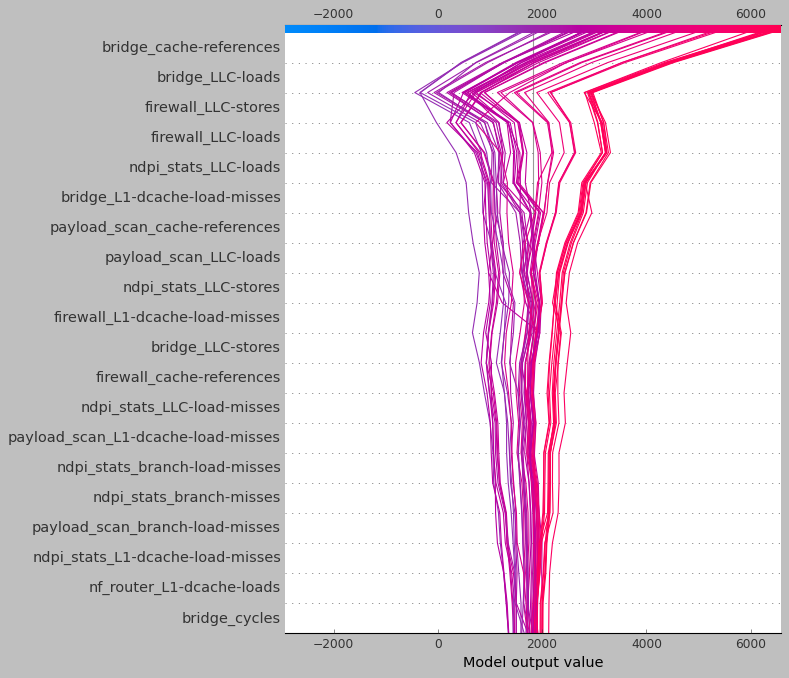

In [418]:
shap.decision_plot(explainer_orig.expected_value, explainer_orig.shap_values(X_test_orig_smaller), shap_values_orig.feature_names)

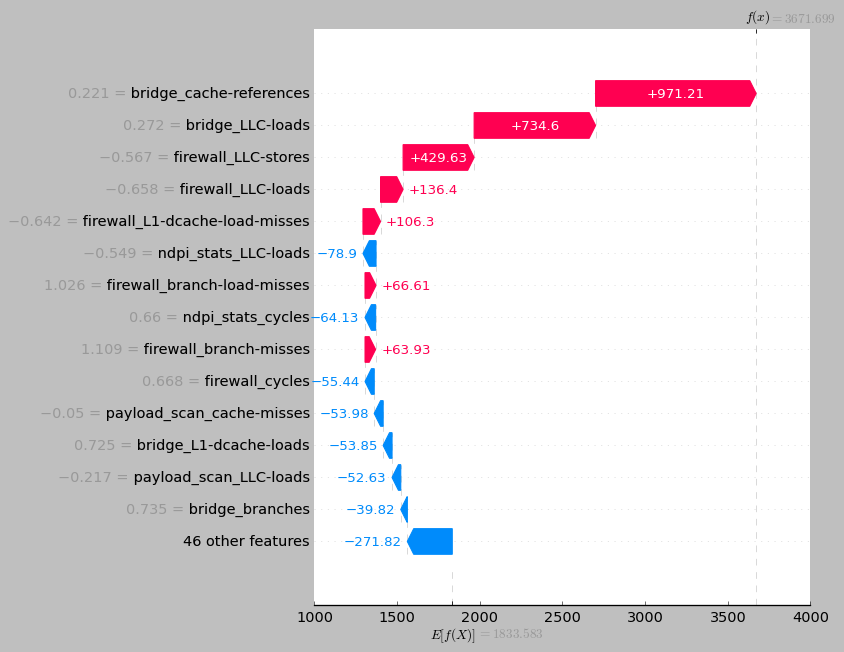

In [379]:
shap.plots.waterfall(shap_values_orig[0], max_display=15)

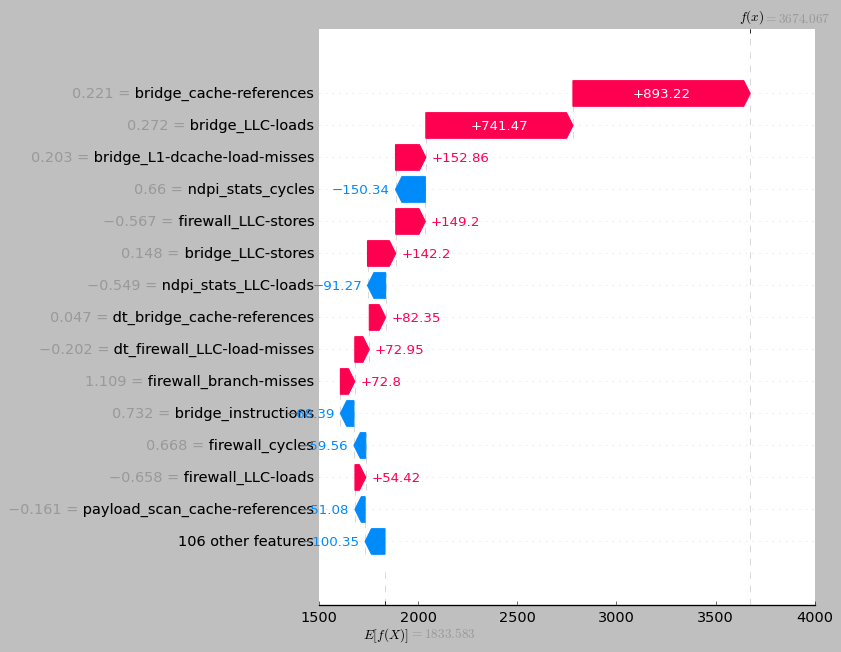

In [380]:
shap.plots.waterfall(shap_values_dt[0], max_display=15)